# Geofísica Matemática y Computacional.

## Examen

### 23 de noviembre de 2021

Antes de entregar este *notebook*, asegúrese de que la ejecución se realiza como se espera.
1. Reinicie el kernel.
    - Para ello seleccione en el menú principal: Kernel$\rightarrow$Restart.
2. Llene todos las celdas que indican:
    - `YOUR CODE HERE` o
    - "YOUR ANSWER HERE"
3. Ponga su nombre en la celda siguiente (y el de sus colaboradores si es el caso).
4. Una vez terminado el ejercicio haga clic en el botón Validate y asegúrese de que no hay ningún error en la ejecución.

In [1]:
NAME = "Jesus Sanchez Gonzalez"
COLLABORATORS = ""

---

# Convección-difusión de calor estacionaria
Considere el siguiente problema:

$$
\begin{eqnarray*}
c_p \rho \frac{\partial}{\partial x} \left( u T \right) -
\frac{\partial }{\partial x} \left( \kappa \frac{\partial T}{\partial x}\right) & = &
S \\
T(0) & = & 1 \\
T(L) & = & 0
\end{eqnarray*}
$$

<img src="conv03.png" width="300" align="middle">

La solución analítica es la siguiente:

$$
\displaystyle
T(x) = \frac{\exp\left(\frac{\rho u x}{\kappa}\right) - 1 }{\exp\left(\frac{\rho v L}{\kappa}\right) - 1} (T_L - T_0) + T_0
$$

Implementar la solución numérica con diferencias finitas en Python.

Utilice los siguientes datos:

- $L = 1.0$ [m], 
- $c_p = 1.0$ [J / Kg $^\text{o}$K], 
- $\rho = 1.0$ [kg/m$^3$], 
- $\kappa = 0.1$ [kg/m s], 
- $S = 0$ 

## Diferencias Centradas
1. Realice la implementación usando el esquema de **Diferencias Centradas para el término advectivo** y haga las siguientes pruebas:

    1. $u = 0.1$ [m/s], con $6$ nodos.<br>    
    2. $u = 2.5$ [m/s], con $6$ nodos.<br>
    3. $u = 2.5$ [m/s], con $N = $ tal que el error sea menor a $0.005$.<br>
    
En todos los casos compare la solución numérica con la analítica calculando el error con la fórmula: $E = ||T_a - T_n||_\infty$. Genere figuras similares a las siguientes:

<table>
    <tr>
        <td><img src="caso1c.png" width="300"></td>
        <td><img src="caso2c.png" width="300"></td>
    </tr>
</table>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# Parámetros para el estilo de las gráficas
plt.style.use('seaborn-paper')
params = {'figure.figsize' : (10,7),
#          'text.usetex'    : True,
          'xtick.labelsize': 20,
          'ytick.labelsize': 20,
          'axes.labelsize' : 24,
          'axes.titlesize' : 24,
          'legend.fontsize': 24,
          'lines.linewidth': 3,
          'lines.markersize': 10,
          'grid.color'     : 'darkgray',
          'grid.linewidth' : 0.5,
          'grid.linestyle' : '--',
          'font.family': 'DejaVu Serif',
         }
plt.rcParams.update(params)

In [3]:
def mesh(L,N):
    """
    Esta función calcula el h y las coordenadas de la malla
    
    Parameters
    ----------
    L : float
    Longitud del dominio.
    
    N : int
    Número de incógnitas (sin las fronteras)
    
    Returns
    -------
    h, x: el tamaño h de la malla y las coordenadas en la dirección x
    """
    # YOUR CODE HERE
    h = L / (N+1)  # tamaño h de la malla
    x = np. linspace (0, L, N+2) # Coordenadas X
    
    return h, x
    

In [4]:
def Laplaciano1D(par):
    """
    Esta función calcula los coeficientes de la matriz de 
    diferencias finitas.
    
    Paremeters
    ----------
    par: dict
    Diccionario que contiene todos los datos del problema.
    
    Returns
    ----------
    A : la matriz de la discretización.
    """
    N     = par['N'] 
    h     = par['h']
    alpha = par['alpha']
    cp    = par['cp']
    rho   = par['rho']
    u     = par['u'] 

    # YOUR CODE HERE
    b = -(u / (2*h)) + (alpha / (h*h)) 
    c = (u / (2*h)) + (alpha / (h*h))
        
    a = b + c
    A = np.zeros((N,N))
    A[0,0] = a 
    A[0,1] = -b
    for i in range(1,N-1):
        A[i,i] = a 
        A[i,i+1] = -b 
        A[i,i-1] = -c 
    A[N-1,N-2] = -c
    A[N-1,N-1] = a
    
    return A

In [5]:
def RHS(par):
    """
    Esta función calcula el lado derecho del sistema lineal.
    
    Paremeters
    ----------
    par: dict
    Diccionario que contiene todos los datos del problema.
    
    Returns
    ----------
    f : el vector del lado derecho del sistema.
    """
    N     = par['N'] 
    h     = par['h']
    alpha = par['alpha']
    cp    = par['cp']
    rho   = par['rho']
    u     = par['u'] 
    T0    = par['BC'][0]
    TL    = par['BC'][1]
    
    f = np.zeros(N)       

    # YOUR CODE HERE
    S = 0
    b = -(u / (2*h)) + (alpha / (h*h)) 
    c = (u / (2*h)) + (alpha / (h*h))
    
    f[:] = S/(cp*rho)
    
    f[0]  = (c * T0)
    f[N-1] = (b * TL)
    
    return f

In [6]:
def plotSol(par, x, T, E):
    """
    Función de graficación de la solución analítica y la numérica
    """
    titulo = 'u = {}, N = {}'.format(par['u'], par['N'])
    error = '$||E||_2$ = {:10.8f}'.format(E)
    plt.figure(figsize=(10,5))
    plt.title(titulo + ', ' + error)
    plt.scatter(x,T, zorder=5, s=100, fc='C1', ec='k', alpha=0.75, label='Numérica')
    plt.plot(x,T, 'C1--', lw=1.0)
    xa, Ta = analyticSol(par)
    plt.plot(xa,Ta,'k-', label='Analítica')
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.3)
    plt.xlabel('x [m]')
    plt.ylabel('T[$^o$C]')
    plt.grid()
    plt.legend(loc='lower left')
    plt.show()

In [7]:
def analyticSol(par, NP = 100):
    """
    Calcula la solución analítica
    
    Paremeters
    ----------
    par: dict
    Diccionario que contiene todos los datos del problema.
    
    NP: int
    Número de puntos para calcular la solución analítica. Si no se da
    ningún valor usa 100 puntos para hacer el cálculo.
    
    Returns
    ----------
    xa, Ta : un arreglo (xa) con las coordenadas donde se calcula la 
       solución analítica y otro arreglo (Ta) con la solución analítica.
    """
    L     = par['L']
    rho   = par['rho']
    u     = par['u']
    alpha = par['alpha']
    T0    = par['BC'][0]
    TL    = par['BC'][1]

    # YOUR CODE HERE
    xa = np.linspace(0, L, NP) # Coordenadas X
    Ta = ((np.exp((rho*u*xa) / alpha)-1) * (TL-T0) /(np.exp((rho*u*L)/alpha)-1))+T0
    
    return xa, Ta

In [8]:
def numSol(par):
    """
    Función que calcula la matriz del sistema (A), el lado derecho (f)
    y con esta información resuelve el sistema lineal para obtener la 
    solución.
    
    Paremeters
    ----------
    par: dict
    Diccionario que contiene todos los datos del problema.
    
    Returns
    ----------
    T : un arreglo (T) con la solución analítica.
    """
    
    # YOUR CODE HERE
    N     = par['N']
    A = Laplaciano1D(par)
    f = RHS(par)
    
    T= np.zeros(N)  # Vector de almacenamiento
    T= np.linalg.solve (A,f)
    
    return T

In [9]:
def error(Ta, Tn):
    """
    Función que calcula el error de la solución numérica.
    
    Paremeters
    ----------
    Ta: array
    Arreglo con la solución analítica.
    
    T: array
    Arreglo con la solución numérica.
    
    Returns
    ----------
    E : float
    Error de la solución numérica con respecto a la analítica.
    """
    # YOUR CODE HERE
    E = np.linalg.norm(Ta-Tn,2)
    return E

In [10]:
def casos(u, N):
    """
    Función para resolver cada caso que usa las funciones anteriores.

    Paremeters
    ----------
    u: float
    Velocidad.
    
    N: int
    Número de incógnitas.
    """    
    # Definición de un diccionario para almancenar los datos del problema
    par = {}
    par['L']     = 1.0 # m
    par['cp']    = 1.0 # [J / Kg K]
    par['rho']   = 1.0 # kg/m^3
    par['u']     = u   # m/s
    par['alpha'] = 0.1 # kg / m.s
    par['BC']    = (1.0, 0.0) # Condiciones de frontera
    par['N']     = N   # Número de incógnitas
    h, x = mesh(par['L'], par['N'])
    par['h'] = h

    # Definición del arreglo donde se almacenará la solución numérica
    N  = par['N']
    T        = np.zeros(N+2)
    T[0]     = par['BC'][0]  # Condición de frontera en x = 0
    T[N+1]   = par['BC'][1]  # Condición de frontera en x = L

    # Se ejecuta la función para obtener la solución
    T[1:N+1] = numSol(par)

    # Se calcula la función para calcular la solución analítica
    _, Ta = analyticSol(par, N+2)

    # Se calcula el error
    Error = error(Ta, T)

    # Se grafica la solución
    plotSol(par, x, T, Error)

### Caso 1.A.
- u = 0.1
- N = 6

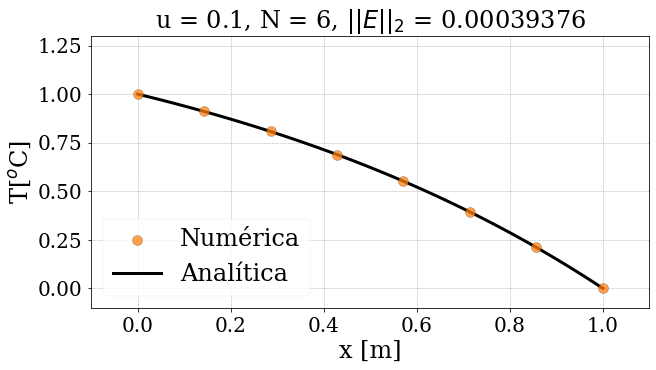

In [11]:
# YOUR CODE HERE
u1 = 0.1
N1 = 6
casos (u1, N1)

### Caso 1.B.
- u = 2.5
- N = 6

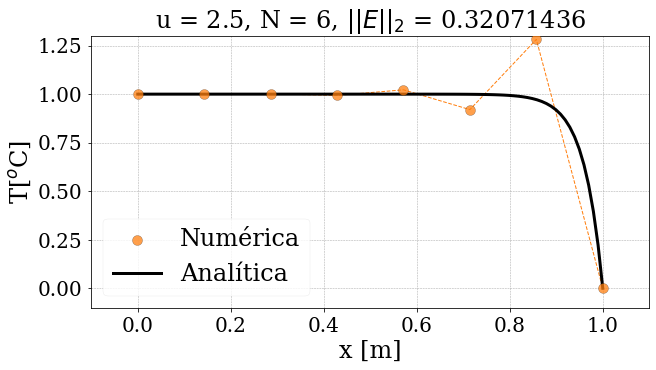

In [12]:
# YOUR CODE HERE
u2 = 2.5
N2 = 6
casos (u2, N2)

### Caso 1.C.
- u = 2.5
- N = ?

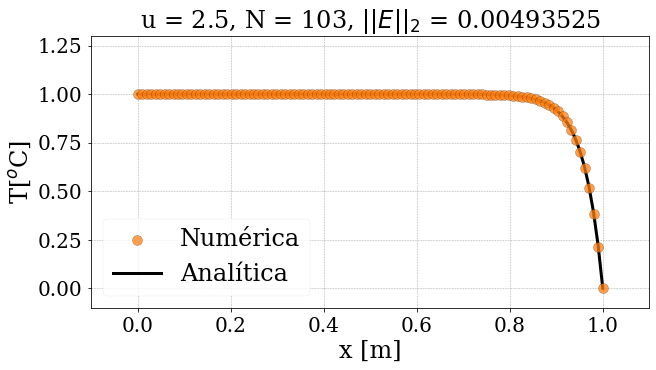

In [13]:
# YOUR CODE HERE
u3 = 2.5
N3 = 103
casos (u3, N3)

## Upwind
2. Realice la implementación usando el esquema **Upwind para el término advectivo** y haga las siguientes pruebas:

    1. $u = 0.1$ [m/s], con $6$ nodos.<br>    
    2. $u = 2.5$ [m/s], con $6$ nodos.<br>
    3. $u = 2.5$ [m/s], con $N = $ tal que el error sea menor a $0.1$.<br>
    
En todos los casos compare la solución numérica con la analítica calculando el error con la fórmula: $E = ||T_a - T_n||_\infty$. Genere figuras similares a las siguientes:

<table>
    <tr>
        <td><img src="caso1u.png" width="300"></td>
        <td><img src="caso2u.png" width="300"></td>
    </tr>
</table>

In [14]:
def Laplaciano1D(par):
    """
    Esta función calcula los coeficientes de la matriz de 
    diferencias finitas.
    
    Paremeters
    ----------
    par: dict
    Diccionario que contiene todos los datos del problema.
    
    Returns
    ----------
    A : la matriz de la discretización.
    """
    N     = par['N'] 
    h     = par['h']
    alpha = par['alpha']
    cp    = par['cp']
    rho   = par['rho']
    u     = par['u'] 

    # YOUR CODE HERE
    b = (alpha / (h*h)) 
    c = (u / h) + (alpha / (h*h))
    
    a = b + c
    A = np.zeros((N,N))
    A[0,0] = a 
    A[0,1] = -b
    for i in range(1,N-1):
        A[i,i] = a 
        A[i,i+1] = -b 
        A[i,i-1] = -c 
    A[N-1,N-2] = -c
    A[N-1,N-1] = a
    
    return A

In [15]:
def RHS(par):
    """
    Esta función calcula el lado derecho del sistema lineal.
    
    Paremeters
    ----------
    par: dict
    Diccionario que contiene todos los datos del problema.
    
    Returns
    ----------
    f : el vector del lado derecho del sistema.
    """
    N     = par['N'] 
    h     = par['h']
    alpha = par['alpha']
    cp    = par['cp']
    rho   = par['rho']
    u     = par['u'] 
    T0    = par['BC'][0]
    TL    = par['BC'][1]
    
    f = np.zeros(N)       

    # YOUR CODE HERE
    S = 0
    b = (alpha / (h*h)) 
    c = (u / h) + (alpha / (h*h))
    
    f[:] = S/(cp*rho)
            
    f[0]   = c * T0  
    f[N-1] = b * TL
    
    return f

### Caso 2.A.
- u = 0.1
- N = 6

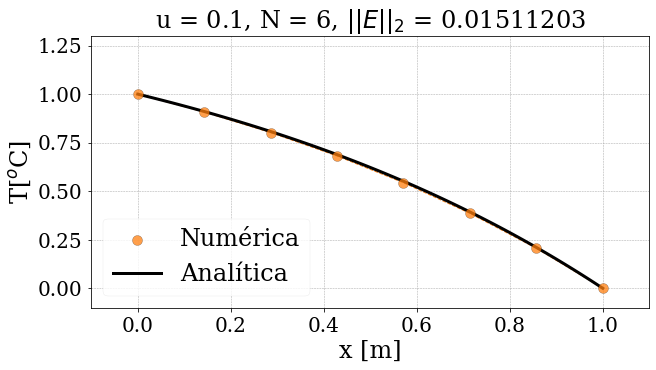

In [16]:
# YOUR CODE HERE
u1 = 0.1
N1 = 6
casos (u1, N1)

### Caso 2.B.
- u = 2.5
- N = 6

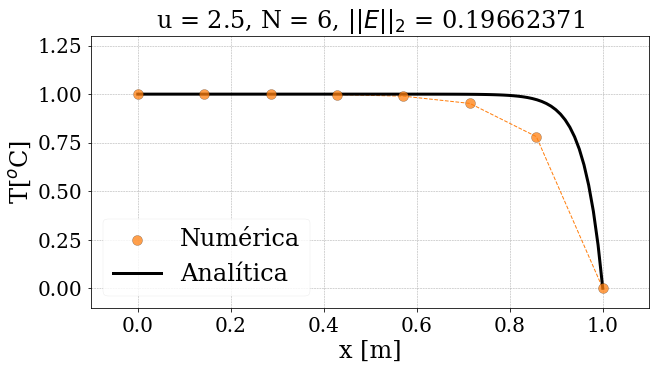

In [17]:
# YOUR CODE HERE
u2 = 2.5
N2 = 6
casos (u2, N2)

### Caso 2.C.
- u = 2.5
- N = ?

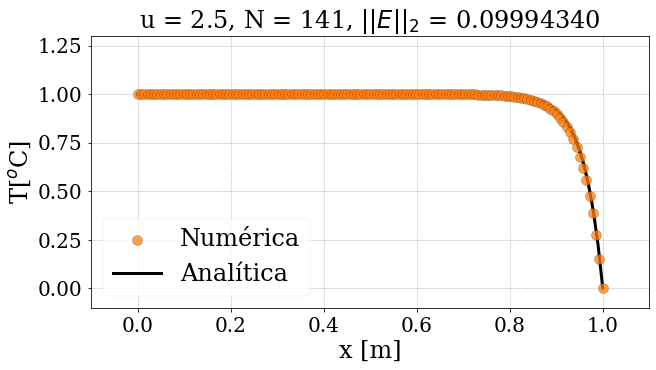

In [18]:
# YOUR CODE HERE
u3 = 2.5
N3 = 141
casos (u3, N3)